In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/NSP_Project'

/content/drive/.shortcut-targets-by-id/1BkwyLE_2RXha2jvki49_Uo_jGPB5CroI/NSP_Project
unzip:  cannot find or open natural_images.zip, natural_images.zip.zip or natural_images.zip.ZIP.


In [ ]:
# 1. Import necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from utils import *
import numpy
import math
import matplotlib.pyplot as plt
!pip install split-folders
import splitfolders
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(1234)
numpy.random.default_rng(2022)

Generator(PCG64) at 0x7F7799A53AA0

In [ ]:
# configurations
DATA_DIR = "./natural_images"
NUM_CLASSES = 8
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [ ]:
class_labels = {0: 'airplane',
                1: 'car',
                2: 'cat',
                3: 'dog',
                4: 'flower',
                5: 'fruit',
                6: 'motorbike',
                7: 'person'}


In [ ]:
# Splitting the dataset into train and test sets
data = DATA_DIR
splitfolders.ratio(data, output='/content/drive/MyDrive/NSP_Project/data',
                   seed=2022, ratio=(.8, .2), group_prefix=None)


Copying files: 6899 files [01:43, 66.81 files/s]


In [ ]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# splitting the train data into train and validation data loading the images
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          validation_split=0.2)

val_data_generator = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.2)

train_data = train_data_generator.flow_from_directory("/content/drive/MyDrive/NSP_Project/data/train", 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='sparse',
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_data_generator.flow_from_directory("/content/drive/MyDrive/NSP_Project/data/train", 
                                           target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='sparse',
                                           shuffle=False,
                                           subset = 'validation')

test_data_generator = ImageDataGenerator(rescale=1./255)
test_data = test_data_generator.flow_from_directory("/content/drive/MyDrive/NSP_Project/data/val",
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='sparse',
                                                    shuffle=False,
                                                    subset=None)

Found 4416 images belonging to 8 classes.
Found 1100 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [ ]:
# getting the class labels
classes = train_data.class_indices
class_labels = {label: class_ for class_, label in classes.items()}
class_labels

{0: 'airplane',
 1: 'car',
 2: 'cat',
 3: 'dog',
 4: 'flower',
 5: 'fruit',
 6: 'motorbike',
 7: 'person'}

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/images/classification#visualize_the_data
def display_images(train_data):
  plt.figure(figsize=(10, 10))
  for i in range(25):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(train_data[0][0][i])
      plt.title(class_labels[train_data[0][1][i]])
      plt.axis("off")


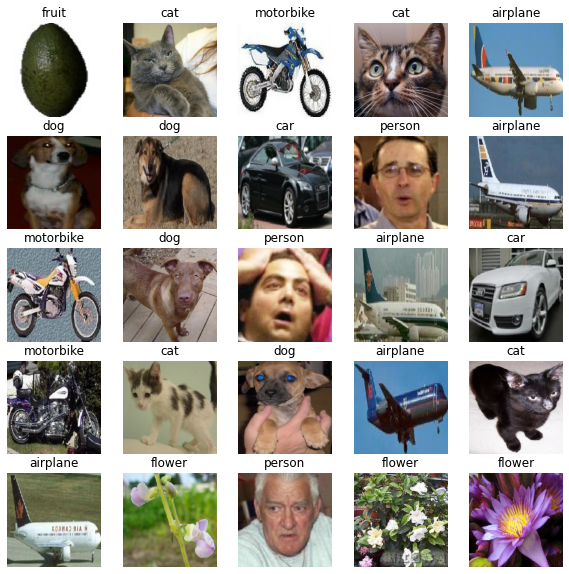

In [ ]:
# displaying samples from train_data
display_images(train_data)

In [ ]:
# Train and Validation samples
TRAIN_SAMPLES = train_data.samples
VALIDATION_SAMPLES = val_data.samples 

#### Model 1

In [ ]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/tutorials/images/classification#model_summary
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
# CNN Base model
def base_model():
  input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
  conv1 = Conv2D(32, kernel_size =(5, 5), activation ='relu')(input)
  pooling1 = MaxPooling2D(pool_size =(2, 2))(conv1)
  conv2 = Conv2D(64, kernel_size =(5, 5), activation ='relu')(pooling1)
  pooling2 = MaxPooling2D(pool_size =(2, 2))(conv2)
  conv3 = Conv2D(32, kernel_size =(3, 3), activation ='relu')(pooling2)
  pooling3 = MaxPooling2D(pool_size =(2, 2))(conv3)
  flatten = Flatten()(pooling3)
  dense = Dense(64, activation='relu')(flatten)
  dropout = Dropout(0.5)(dense)
  output = Dense(NUM_CLASSES, activation='softmax')(dropout)

  return Model(inputs=input, outputs=output)

base_model = base_model()
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 32)        18464 

In [ ]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/tutorials/images/classification#model_summary
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
# https://www.tensorflow.org/tutorials/images/classification#train_the_model
# 3. Train the model
base_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=['acc'])
history_base_model = base_model.fit(
    train_data,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE),
    epochs=10,
    validation_data=val_data,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE))

Epoch 1/10
69/69 [==============================] - 31s 407ms/step - loss: 1.4066 - acc: 0.4817 - val_loss: 0.7890 - val_acc: 0.7318
Epoch 2/10
69/69 [==============================] - 27s 391ms/step - loss: 0.7899 - acc: 0.7147 - val_loss: 0.4970 - val_acc: 0.8282
Epoch 3/10
69/69 [==============================] - 27s 388ms/step - loss: 0.5903 - acc: 0.7817 - val_loss: 0.4662 - val_acc: 0.8327
Epoch 4/10
69/69 [==============================] - 27s 387ms/step - loss: 0.5509 - acc: 0.7912 - val_loss: 0.3959 - val_acc: 0.8709
Epoch 5/10
69/69 [==============================] - 27s 392ms/step - loss: 0.4508 - acc: 0.8202 - val_loss: 0.4029 - val_acc: 0.8564
Epoch 6/10
69/69 [==============================] - 31s 454ms/step - loss: 0.3819 - acc: 0.8458 - val_loss: 0.3726 - val_acc: 0.8764
Epoch 7/10
69/69 [==============================] - 32s 468ms/step - loss: 0.3602 - acc: 0.8576 - val_loss: 0.3174 - val_acc: 0.8809
Epoch 8/10
69/69 [==============================] - 28s 406ms/step - 

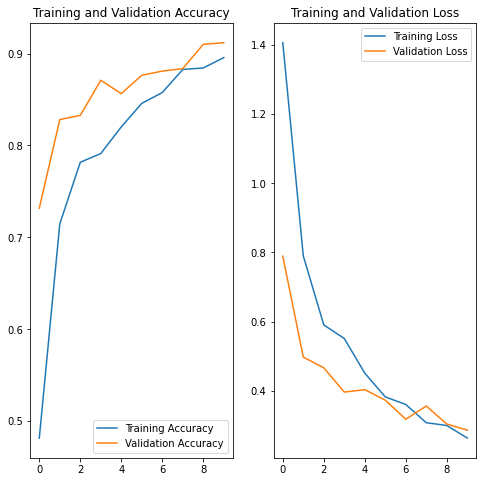

In [ ]:
model_metrics(history_base_model)

In [ ]:
#Reference: https://www.programcreek.com/python/example/89223/keras.preprocessing.image.load_img
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
def image_prediction(model, img_path):
    plt.figure(figsize=(5, 5))
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array/255.
    prediction = model.predict(preprocessed_img)
    prediction_class = prediction.argmax(axis=1)
    plt.imshow(img)
    plt.title(str(class_labels[int(prediction_class)])+'|'+str(100*np.max(prediction)))



22/22 [==============================] - 8s 344ms/step - loss: 0.3209 - acc: 0.8908
Accuracy on test set: 0.8908170461654663


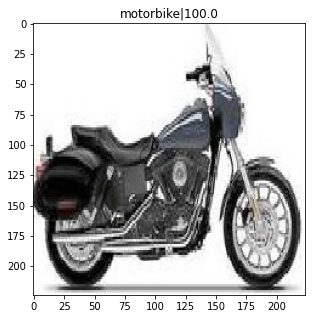

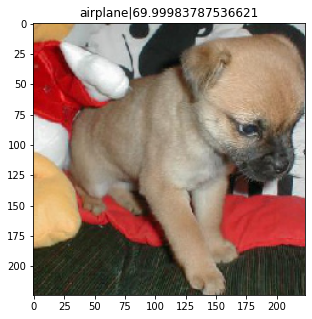

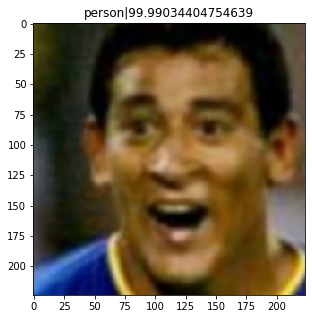

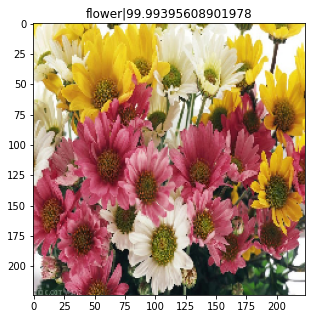

In [ ]:
# Saving the model
base_model.save('/content/drive/MyDrive/NSP_Project/base_model.h5')

# 5. Model Prediction
model = load_model('/content/drive/MyDrive/NSP_Project/base_model.h5')

# Evaluating the model on test set
print(f'Accuracy on test set: {model.evaluate(test_data)[1]}')

# Classifying random images
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/motorbike/motorbike_0011.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/dog/dog_0200.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/person/person_0319.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/flower/flower_0475.jpg')

#### MobileNet pretrained model

In [ ]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
def model_maker():
    base_model = MobileNet(include_top=False,
                          input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable=False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

mobilenet_model = model_maker()
mobilenet_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                            

In [ ]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/tutorials/images/classification#train_the_model
# 3. Train the model
mobilenet_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=['acc'])
history_mobilenet = mobilenet_model.fit(
    train_data,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE),
    epochs=10,
    validation_data=val_data,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE))

Epoch 1/10
69/69 [==============================] - 29s 391ms/step - loss: 0.5070 - acc: 0.8424 - val_loss: 0.0277 - val_acc: 0.9918
Epoch 2/10
69/69 [==============================] - 27s 384ms/step - loss: 0.0809 - acc: 0.9798 - val_loss: 0.0146 - val_acc: 0.9964
Epoch 3/10
69/69 [==============================] - 25s 368ms/step - loss: 0.0505 - acc: 0.9882 - val_loss: 0.0136 - val_acc: 0.9973
Epoch 4/10
69/69 [==============================] - 26s 375ms/step - loss: 0.0377 - acc: 0.9894 - val_loss: 0.0137 - val_acc: 0.9964
Epoch 5/10
69/69 [==============================] - 26s 370ms/step - loss: 0.0296 - acc: 0.9923 - val_loss: 0.0109 - val_acc: 0.9973
Epoch 6/10
69/69 [==============================] - 26s 381ms/step - loss: 0.0213 - acc: 0.9959 - val_loss: 0.0085 - val_acc: 0.9982
Epoch 7/10
69/69 [==============================] - 26s 373ms/step - loss: 0.0228 - acc: 0.9923 - val_loss: 0.0071 - val_acc: 0.9973
Epoch 8/10
69/69 [==============================] - 26s 376ms/step - 

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/keras/save_and_load
# 4. Save the model
mobilenet_model.save('/content/drive/MyDrive/NSP_Project/mobilenet_model.h5')

22/22 [==============================] - 7s 293ms/step - loss: 0.0098 - acc: 0.9964
Accuracy on test set: 0.9963846802711487


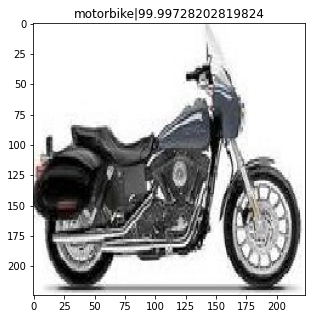

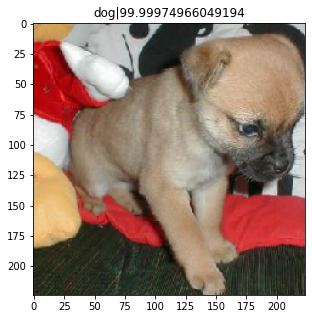

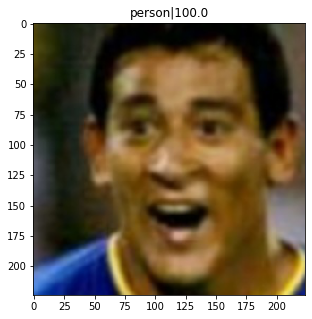

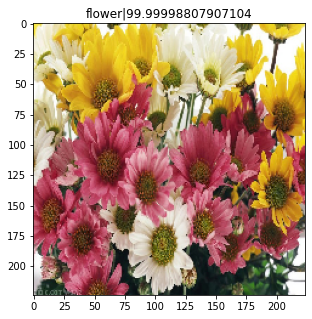

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/keras/save_and_load
# 5. Loading the model
model = load_model('/content/drive/MyDrive/NSP_Project/mobilenet_model.h5')

# Evaluating the model on test set
print(f'Accuracy on test set: {model.evaluate(test_data)[1]}')

# Classifying random images
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/motorbike/motorbike_0011.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/dog/dog_0200.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/person/person_0319.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/flower/flower_0475.jpg')


In [ ]:
# Reference: https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
def model_metrics(history):
  epochs=10
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


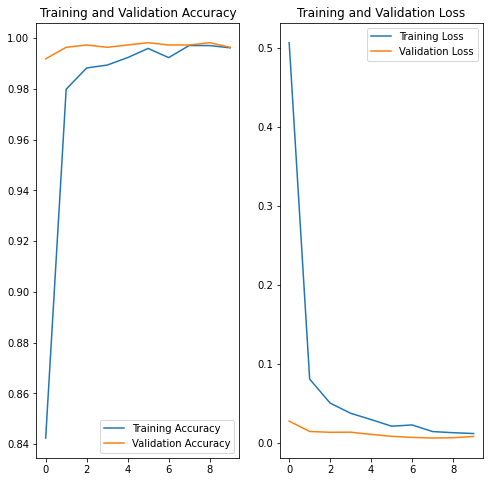

In [ ]:
model_metrics(history_mobilenet)

### Data Augmentation

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/images/data_augmentation

train_data_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=20,
                                          validation_split=0.2)

val_data_generator = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.2)

train_data = train_data_generator.flow_from_directory(DATA_DIR, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='sparse',
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_data_generator.flow_from_directory(DATA_DIR, 
                                           target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='sparse',
                                           shuffle=False,
                                           subset = 'validation')

# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/tutorials/images/classification#train_the_model
mobilenet_model_1 = model_maker()
mobilenet_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=['acc'])
history_mobilenet_1 = mobilenet_model.fit(
    train_data,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE),
    epochs=10,
    validation_data=val_data,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE))

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.
Epoch 1/10
69/69 [==============================] - 76s 1s/step - loss: 0.1294 - acc: 0.9577 - val_loss: 0.0143 - val_acc: 0.9931
Epoch 2/10
69/69 [==============================] - 75s 1s/step - loss: 0.0819 - acc: 0.9751 - val_loss: 0.0111 - val_acc: 0.9957
Epoch 3/10
69/69 [==============================] - 75s 1s/step - loss: 0.0678 - acc: 0.9778 - val_loss: 0.0192 - val_acc: 0.9939
Epoch 4/10
69/69 [==============================] - 77s 1s/step - loss: 0.0648 - acc: 0.9771 - val_loss: 0.0128 - val_acc: 0.9931
Epoch 5/10
69/69 [==============================] - 74s 1s/step - loss: 0.0499 - acc: 0.9826 - val_loss: 0.0197 - val_acc: 0.9931
Epoch 6/10
69/69 [==============================] - 80s 1s/step - loss: 0.0448 - acc: 0.9854 - val_loss: 0.0162 - val_acc: 0.9948
Epoch 7/10
69/69 [==============================] - 76s 1s/step - loss: 0.0466 - acc: 0.9830 - val_loss: 0.0187 - val_acc: 0.9939
Epoch 

22/22 [==============================] - 7s 282ms/step - loss: 0.0080 - acc: 0.9978
Accuracy on test set: 0.9978308081626892


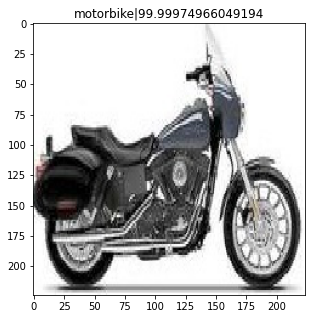

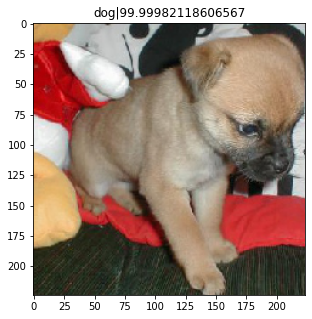

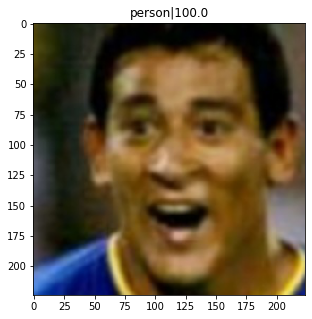

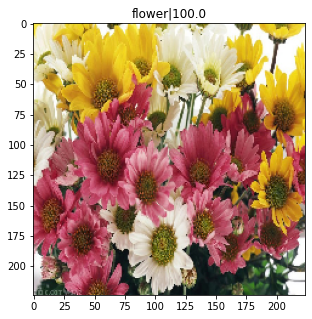

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/keras/save_and_load
mobilenet_model.save('/content/drive/MyDrive/NSP_Project/mobilenet_model_v2.h5')

# 5. Model Prediction
# loading the model
model = load_model('/content/drive/MyDrive/NSP_Project/mobilenet_model_v2.h5')

# Evaluating the model on test set
print(f'Accuracy on test set: {model.evaluate(test_data)[1]}')

# Classifying random images
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/motorbike/motorbike_0011.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/dog/dog_0200.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/person/person_0319.jpg')
image_prediction(model, '/content/drive/MyDrive/NSP_Project/natural_images/flower/flower_0475.jpg')

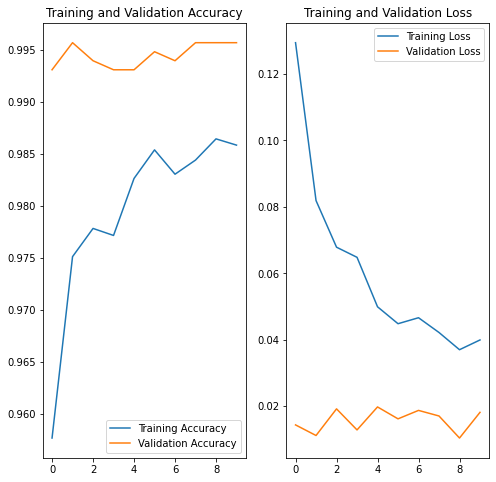

In [ ]:
model_metrics(history_mobilenet_1)